# Optimal restarts

A [Las Vegas algorithm](https://en.wikipedia.org/wiki/Las_Vegas_algorithm) is an algorithm with an *uncertain* runtime, but *certain* correctness.  In other words,  if such an algorithm halts, its output will be correct, but the time until it halts is a random variable.  Thus, the algorithm has a runtime *distribution*.  Today, I will talk about a general *acceleration* strategies for such algorithms based on random restarts.

**Familiar example:** Quicksort.

**Synthetic example:** ???

**The random restart wrapper:**

The generic strategy for accelerating Las Vegas algorithms will determine an optimal runtime time limit (threshold) as a function of the algorithm's runtime distribution, which&mdash;at least for the time being&mdash;we shall assume is known to the algorithm.

In [19]:
from arsenal import timelimit, Timeout, restore_random_state
def restart_acceleration(alg, policy):
    for seed in random_seeds():      # loop over an unbounded sequence of random seeds
        t = policy()
        try:
            # Run `alg` for `y` seconds under a given random `seed`.
            with timelimit(t), restore_random_state(seed):
                return alg()            # if the algorithm halted, output result
        except Timeout:
            pass

About the code:
- Explicit control over random seeds is not required, but is nice to have when it is available.  Since we are working with algorithm, we will generally have control over the random seed.

if the algorithm halted within the chosen time limit, the wrapper also halts with the algorithm's result.
otherwise, the wrapper runs the algorithms again, hoping to get luckier.

The original work is 
Luby, Sinclair, and Zuckerman (1993)
[Optimal Speedup of Las Vegas Algorithms](http://http.icsi.berkeley.edu/ftp/global/pub/techreports/1993/tr-93-010.pdf)

TODO: Give refs to the better papers.

Some surprising results:

- When the runtime distribution is known, the optimal policy for runtime budgets is a fixed constant threshold! This is somewhat surprising - I will give a simple arugment for why it is true.  

- When the runtime distribution is not known there exists a universal strategy, which retries under an universal sequence of runtime thresholds.

**TODO**: add restart overhead to all methods/analyses.

In [20]:
import numpy as np, pylab as pl, scipy.stats as st
from arsenal.maths import mean_confidence_interval
from scipy.integrate import quad
from arsenal import iterview

# define a runtime distribution
#d = st.lognorm(1.5)
d = st.pareto(1.25)   # variance is infinite for <2
tmin = 1.1
tmax = d.mean()*2

m = d.mean()
s = d.std()
print(m, s)

5.0 inf


In [21]:
# TODO: the truncated means (a,b) and (a,b+Δ) duplicate a lot work
@np.vectorize
def truncated_mean(a, b):
    "E[T | a <= T <= b]"
    p = d.cdf(b) - d.cdf(a)
    if p == 0: return np.inf
    [est, _] = quad(lambda x: x * d.pdf(x), a, b) 
    return est / p

Heavy-tailed distribution
- [Pareto](https://en.wikipedia.org/wiki/Pareto_distribution)  
- [Log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution)

Some others Weibull, Zipf, Cauchy, Student's t, Frechet

In [22]:
def T(R):
    "Expected runtime with restart threshold `R`"
    p = d.cdf(R)
    return R * (1-p)/p + truncated_mean(0, R)

In [23]:
ts = np.linspace(tmin, tmax, 100)
Ts = T(ts)

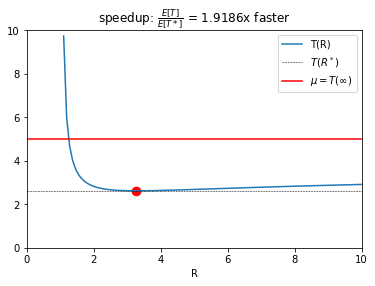

In [24]:
pl.plot(ts, Ts, label=r'T(R)')
pl.scatter(ts[Ts.argmin()], [Ts.min()], marker='o', c='r', s=75)
pl.xlim(ts.min(), ts.max()) ; pl.ylim(0, m*2)

rstar = ts[Ts.argmin()]
Tstar = d.sf(rstar) / d.pdf(rstar)   # analytical-ish

pl.title(r'speedup: $\frac{E[T]}{E[T*]}$ = %gx faster' % (m/Tstar))
pl.axhline(Tstar, c='k', lw=0.5, linestyle='--', label=r'$T(R^*)$');
pl.axhline(d.mean(), c='r', label=r'$\mu = T(\infty)$')

pl.xlim(0, ts.max()); pl.legend(loc='best'); pl.xlabel('R'); #pl.xscale('log'); pl.yscale('log');

## Universal strategy

The expected runtime of the universal strategy is $\mathcal{O}(T(\tau^*) \log T(\tau^*))$

TODO compare this sequence to the simple doubling sequence.

In [25]:
from arsenal.iterextras import take
def universal(scale, base=2.0):
    "Generate the universal threshold sequence"
    assert base > 1
    i = 0
    while True:
        i += 1
        for j in range(i):
            yield scale * base**j

assert list(take(15, universal(1, 2))) == [
    1, 
    1, 2, 
    1, 2, 4, 
    1, 2, 4, 8, 
    1, 2, 4, 8, 16
]

In [26]:
def _simulate(policy, seed):
    with restore_random_state(seed):
        total = 0.0
        while True:
            r = d.rvs()
            R = policy()
            total += min(r, R)
            if r <= R:
                return total

p = universal(0.01, 2)
print('universal:',
    d.mean(),
    _simulate(p.__next__, seed=0)
)
print('baseline: ', d.mean(), d.std())

universal: 5.0 7.340947603538684
baseline:  5.0 inf


## Derivation

The following recursive definition of the expected value under the policy $\tau$ is essentially a two-state MDP (a terminal and non-terminal state) with actions corresponding to the threshold values. The analysis will be agnostic to whether $\tau$ is discrete or continuous.

$$
v = \mathbb{E}_p[ \min(t, \tau) ]    +   (1 - p( t \le \tau)) \cdot (overhead + \tau + v)
%           immediate cost        prob retry      retry      retry
%            of the run                         overhead
$$

where overhead $\ge 0$ is a known, constant restart-overhead penalty.

Solving the recurrence for v, we obtain

$$
\begin{align}
  v &= \mathbb{E}_p[t |t \le \tau] + \frac{1-p(t \le \tau)}{p(t \le \tau)} \cdot (overhead + \tau).
\end{align}
$$

Although, the analysis below does not directly show this.  We know that all MDPs have and optimal policy that is pure and stationary (i.e., deterministic and fixed over time).

Remarks: The expected value isn't the only reason choice of what to optimize.  It is possible minimize higher-order moments (e.g., variance) as well as the expected value.  It is also possible to minimize quantiles.

### Optimizing $\tau$

In the discrete case, the optimal $\tau$ can be computed by enumeration. 
**TODO** It is not that simple because $\tau$ may have infinite support. Are there bounds / ordering that can be exploited to get a finite-time algorithm?

In the continuous case, the optimal $\tau$ can be computed in "the usual way" (i.e., by solving for $\tau$ such that $\frac{\partial v}{\partial \tau}$ is equal to zero; and check the sign of the second derivative).  The derivative is

$$
\frac{\partial v}{\partial \tau}
= \frac{1-p(t \le \tau)}{p(t \le \tau)} - \frac{p(\tau)}{p(t \le \tau)} \cdot v
$$

Solve for $\tau$ such that the derivative is zero.
$$
\begin{align}
\frac{\partial v}{\partial \tau} &= 0 \\
\frac{1-p(t \le \tau)}{p(t \le \tau)} &= \frac{p(\tau)}{p(t \le \tau)} \cdot v \\
\frac{1-p(t \le \tau)}{p(\tau)} &= v \\
\end{align}
$$

Remarks

- The optimally capped expectation (as well as higher-order moments) are always finite - even when the underlying RTD puts positive probability on nontermination.

- Optimally tuned thresholds do not always decrease the expected runtime (or higher-order moments).  They are most useful in cases where the runtime distribution has a positive probability of nontermination or, more generally, the runtime distribution is heavy tailed.

## Unit tests

### Testing truncated mean

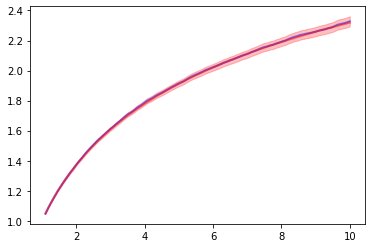

In [27]:
# test that the right-truncated mean estimate matches rejection sampling
N = 10000
S = d.rvs(N)

# a more efficient estimator would generate truncated samples so all samples are 'accepted' 
def simulate(t):
    return mean_confidence_interval(S[S <= t])

mi,lb,ub = zip(*[simulate(t) for t in ts])
pl.fill_between(ts, lb, ub, color='r', alpha=0.25)
pl.plot(ts, mi, c='b', alpha=0.5, lw=2)
pl.plot(ts, truncated_mean(0, ts), c='r', lw=2, alpha=0.5);

### Optimality conditions

Here we check whether the optimality conditions that we derived are correct.

It is currently just an eye ball test that the optimal speedup is at the point 
where the capped_runtime(t) curve (blue) and 1/hazard_rate(t) curve (orange) intersect


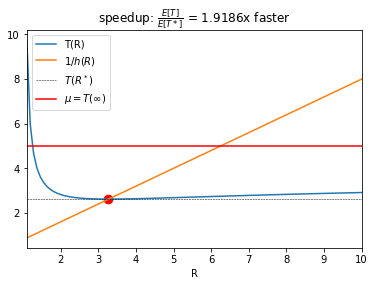

In [28]:
H = lambda t: d.pdf(t)/d.sf(t)   # hazard-rate function

pl.plot(ts, Ts, label=r'T(R)')
pl.plot(ts, 1/H(ts), label=r'$1/h(R)$')     # inverse of the hazard-rate function
pl.scatter(ts[Ts.argmin()], [Ts.min()], marker='o', c='r', s=75)
pl.xlim(ts.min(), ts.max()) #; pl.ylim(0, m*2)

rstar = ts[Ts.argmin()]
Tstar = d.sf(rstar) / d.pdf(rstar)   # analytical-ish

pl.title(r'speedup: $\frac{E[T]}{E[T*]}$ = %gx faster' % (m/Tstar))
pl.axhline(Tstar, c='k', lw=0.5, linestyle='--', label=r'$T(R^*)$');
pl.axhline(d.mean(), c='r', label=r'$\mu = T(\infty)$')
pl.legend(loc='best'); pl.xlabel('R'); #pl.xscale('log'); pl.yscale('log')

### Alternative expressions for expected capped runtime $T$

$$
T(\tau) = \mathbb{E}_p[t |t \le \tau] + \frac{1-p(t \le \tau)}{p(t \le \tau)} \cdot (overhead + \tau).
$$

Equation (2.12) for [Gaglilio's thesis](file:///home/timv/Desktop/read/algorithm-configuration/Gagliolo/Gagliolo-thesis.pdf) provides alternative expression for the expected capped runtime.

$$
T(\tau) 
= \frac{\tau - \int_{0}^\tau F(t) \mathrm{d} t}{ F(\tau) }
= \frac{\int_{0}^\tau S(t) \mathrm{d} t}{ 1 - S(\tau) }
$$


where $F$ is the CDF of the runtime distribution, and $S$ is the survival function $S(t) \overset{\text{def}}{=} (1-F(t))$.

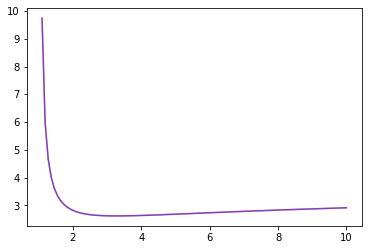

In [41]:
@np.vectorize
def L(b):
    "Equivalent expression for expected runtime given the threshold `b`."
    return (b - quad(lambda x: d.cdf(x), 0, b)[0]) / d.cdf(b)

@np.vectorize
def L2(b):
    "Equivalent expression for expected runtime given the threshold `b`."
    return quad(lambda x: d.sf(x), 0, b)[0] / (1 - d.sf(b))

L2s = L2(ts)
Ls = L(ts)

pl.plot(ts, L2s, label=r'$L_2(R)$', c='r', alpha=0.5)
#pl.plot(ts, Ls, label=r'$L(R)$', c='r', alpha=0.5)
pl.plot(ts, Ts, label=r'$T(R)$', c='b', alpha=0.5)

rerr = np.abs(Ts - L2s) / np.abs(Ts)
assert rerr.max() <= 1e-3, rerr

rerr = np.abs(Ts - Ls) / np.abs(Ts)
assert rerr.max() <= 1e-3, rerr

### Test expected capped runtime

100.0% (100/100) [====================================================] 00:00:09


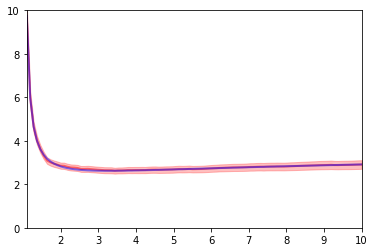

In [42]:
def simulate(R, seeds):
    
    def _simulate(R, seed):
        "simulate capped-restart distribution"
        with restore_random_state(seed):
            total = 0.0
            while True:
                r = d.rvs()
                total += min(r, R)            
                if r <= R:
                    return total
    
    return [_simulate(R, seed) for seed in seeds]

M = 1000
seeds = np.random.randint(0, 2**32, size=M).astype(int)

mi,lb,ub = zip(*[mean_confidence_interval(simulate(t, seeds)) for t in iterview(ts)])
pl.fill_between(ts, lb, ub, color='r', alpha=0.25)
pl.plot(ts, mi, c='r', alpha=0.5, lw=2)
pl.plot(ts, Ts, c='b', alpha=0.5, lw=2); pl.ylim(0, m*2)
pl.xlim(ts.min(), ts.max());

### Runtime distribution conditioned on capping

In [43]:
def capped_cdf(τ):
    "Analytical CDF conditioned on a capping threshold τ."
    p = d.cdf(τ)
    def F(t):
        if t <= τ: return d.cdf(t)
        return p + (1-p) * F(t - τ)
    return F

Let's validate our analytical cdf against the empirical CDF.

In [14]:
from arsenal.maths import cdf

M = 160000
seeds = np.random.randint(0, 2**32, size=M).astype(int)
e = cdf(simulate(rstar, seeds))   # empirical CDF of the optimal threshold.

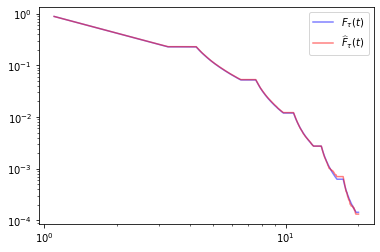

In [15]:
C = capped_cdf(rstar)

ts = np.linspace(tmin, 4*m, 1000)   # estimate gets unreliable out in the tail
Cs = [1-C(t) for t in ts]

pl.plot(ts, Cs, label=r'$F_\tau(t)$', c='b', alpha=0.5)
pl.plot(ts, 1-e(ts), label=r'$\widehat{F}_\tau(t)$', c='r', alpha=0.5)
pl.legend(loc='best'); pl.yscale('log'); pl.xscale('log');

### Capping eliminates heavy tails

log-log survival plot:  This plot show us if we have heavy tails: a heavy-tailed distribution will have a linear slope and a light-tailed distributions will go to zero more quickly than linear.

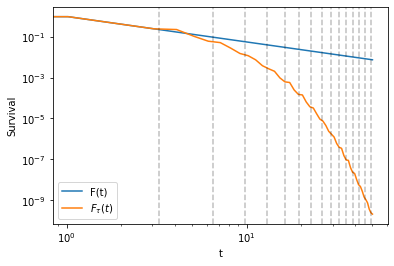

In [16]:
ts = np.linspace(0, 10*m, 50)   # estimate gets unreliable out in the tail

pl.loglog(ts, 1-d.cdf(ts), label='F(t)')
pl.loglog(ts, [1-C(t) for t in ts], label=r'$F_\tau(t)$')

for i in range(int(ts.max() / rstar)+1):
    pl.axvline(i * rstar, alpha=0.25, c='k', linestyle='--')

pl.xlabel('t'); pl.ylabel('Survival'); pl.legend(loc='best');